# Fraud Detection for Automobile Claims: Create an End to End Pipeline

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/end_to_end|fraud_detection|pipeline-e2e.ipynb)

---

## Background

In this notebook, we will build a SageMaker Pipeline that automates the entire end-to-end process of preparing, training, and deploying a model that detects automobile claim fraud. For a more detailed explanation of each step of the pipeline, you can look the series of notebooks (listed below) that implements this same process using a manual approach. Please see the [README.md](README.md) for more information about this use case implemented by this series of notebooks. 


1. [Fraud Detection for Automobile Claims: Data Exploration](./0-AutoClaimFraudDetection.ipynb)
1. [Fraud Detection for Automobile Claims: Data Preparation, Process, and Store Features](./1-data-prep-e2e.ipynb)
1. [Fraud Detection for Automobile Claims: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
1. [Fraud Detection for Automobile Claims: Mitigate Bias, Train, Register, and Deploy Unbiased Model](./3-mitigate-bias-train-model2-registry-e2e.ipynb)


## Contents
1. [Prerequisites](#Prerequisites)
1. [Architecture: Create a SageMaker Pipeline to Automate All the Steps from Data Prep to Model Deployment](#Architecture:-Create-a-SageMaker-Pipeline-to-Automate-All-the-Steps-from-Data-Prep-to-Model-Deployment)
1. [Creating an Automated Pipeline using SageMaker Pipeline](#Creating-an-Automated-Pipeline-using-SageMaker-Pipeline)
1. [Clean-Up](#Clean-Up)

## Prerequisites
----

### Install required and/or update third-party libraries

In [ ]:
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.14.0 imbalanced-learn==0.7.0 sagemaker==2.41.0

### Import libraries

In [ ]:
import json
import boto3
import pathlib
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import string

import demo_helpers

from sagemaker.xgboost.estimator import XGBoost
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CreateModelStep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString

### Set region and boto3 config

In [ ]:
# You can change this to a region of your choice
import sagemaker

region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client("sts").get_caller_identity()["Account"]

bucket = sagemaker_session.default_bucket()
prefix = "fraud-detect-demo"

claims_fg_name = f"{prefix}-claims"
customers_fg_name = f"{prefix}-customers"

In [ ]:
# ======> Tons of output_paths

training_job_output_path = f"s3://{bucket}/{prefix}/training_jobs"
bias_report_output_path = f"s3://{bucket}/{prefix}/clarify-bias"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-explainability"

train_data_uri = f"s3://{bucket}/{prefix}/data/train/train.csv"
test_data_uri = f"s3://{bucket}/{prefix}/data/test/test.csv"
train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/train/upsampled/train.csv"
processing_dir = "/opt/ml/processing"
create_dataset_script_uri = f"s3://{bucket}/{prefix}/code/create_dataset.py"
pipeline_bias_output_path = f"s3://{bucket}/{prefix}/clarify-output/pipeline/bias"
deploy_model_script_uri = f"s3://{bucket}/{prefix}/code/deploy_model.py"

# ======> variables used for parameterizing the notebook run
flow_instance_count = 1
flow_instance_type = "ml.m5.4xlarge"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

deploy_model_instance_type = "ml.m4.xlarge"

## Architecture: Create a SageMaker Pipeline to Automate All the Steps from Data Prep to Model Deployment
----

![End to end pipeline architecture](./images/e2e-5-pipeline-v3b.png)

## Creating an Automated Pipeline using SageMaker Pipeline

- [Step 1: Claims Data Wrangler Preprocessing Step](#Step-1:-Claims-Data-Wrangler-Preprocessing-Step)
- [Step 2: Customers Data Wrangler Preprocessing Step](#Step-2:-Customers-Data-Wrangler-Preprocessing-Step)
- [Step 3: Create Dataset and Train/Test Split](#Step-3:-Create-Dataset-and-Train/Test-Split)
- [Step 4: Train XGBoost Model](#Step-4:-Train-XGBoost-Model)
- [Step 5: Model Pre-Deployment Step](#Step-5:-Model-Pre-Deployment-Step)
- [Step 6: Run Bias Metrics with Clarify](#Step-6:-Run-Bias-Metrics-with-Clarify)
- [Step 7: Register Model](#Step-7:-Register-Model)
- [Step 8: Deploy Model](#Step-8:-Deploy-Model)
- [Step 9: Combine and Run the Pipeline Steps](#Step-9:-Combine-and-Run-the-Pipeline-Steps)




----
Now that youve manually done each step in our machine learning workflow, you can certain steps to allow for faster model experimentation without sacrificing transparncy and model tracking. In this section you will create a pipeline which trains a new model, persists the model in SageMaker and then adds the model to the registry.

### Pipeline parameters
An important feature of SageMaker Pipelines is the ability to define the steps ahead of time, but be able to change the parameters to those steps at execution without having to re-define the pipeline. This can be achieved by using ParameterInteger, ParameterFloat or ParameterString to define a value upfront which can be modified when you call `pipeline.start(parameters=parameters)` later. Only certain parameters can be defined this way.

In [ ]:
train_instance_param = ParameterString(
    name="TrainingInstance",
    default_value="ml.m4.xlarge",
)

model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

### Step 1: Claims Data Wrangler Preprocessing Step

### Upload raw data to S3
Before you can preprocess the raw data with Data Wrangler, it must exist in S3.

In [ ]:
s3_client.upload_file(
    Filename="data/claims.csv", Bucket=bucket, Key=f"{prefix}/data/raw/claims.csv"
)
s3_client.upload_file(
    Filename="data/customers.csv", Bucket=bucket, Key=f"{prefix}/data/raw/customers.csv"
)

### Update attributes within the  `.flow` file 
Data Wrangler will generate a .flow file. It contains a reference to an S3 bucket used during the Wrangling. This may be different from the one you have as a default in this notebook eg if the Wrangling was done by someone else, you will probably not have access to their bucket and you now need to point to your own S3 bucket so you can actually load the .flow file into Data Wrangler or access the data.

After running the cell below you can open the `claims.flow` and `customers.flow` files and export the data to S3 or you can continue the guide using the provided `data/claims_preprocessed.csv` and `data/customers_preprocessed.csv` files.

In [ ]:
claims_flow_template_file = "claims_flow_template"

with open(claims_flow_template_file, "r") as f:
    variables = {"bucket": bucket, "prefix": prefix}
    template = string.Template(f.read())
    claims_flow = template.substitute(variables)
    claims_flow = json.loads(claims_flow)

with open("claims.flow", "w") as f:
    json.dump(claims_flow, f)

customers_flow_template_file = "customers_flow_template"

with open(customers_flow_template_file, "r") as f:
    variables = {"bucket": bucket, "prefix": prefix}
    template = string.Template(f.read())
    customers_flow = template.substitute(variables)
    customers_flow = json.loads(customers_flow)

with open("customers.flow", "w") as f:
    json.dump(customers_flow, f)

#### Upload flow to S3
This will become an input to the first step and, as such, needs to be in S3.

In [ ]:
s3_client.upload_file(
    Filename="claims.flow", Bucket=bucket, Key=f"{prefix}/dataprep-notebooks/claims.flow"
)
claims_flow_uri = f"s3://{bucket}/{prefix}/dataprep-notebooks/claims.flow"
print(f"Claims flow file uploaded to S3")

#### Define the first Data Wrangler step's inputs

In [ ]:
with open("claims.flow", "r") as f:
    claims_flow = json.load(f)

flow_step_inputs = []

# flow file contains the code for each transformation
flow_file_input = sagemaker.processing.ProcessingInput(
    source=claims_flow_uri, destination=f"{processing_dir}/flow", input_name="flow"
)

flow_step_inputs.append(flow_file_input)

# parse the flow file for S3 inputs to Data Wranger job
for node in claims_flow["nodes"]:
    if "dataset_definition" in node["parameters"]:
        data_def = node["parameters"]["dataset_definition"]
        name = data_def["name"]
        s3_input = sagemaker.processing.ProcessingInput(
            source=data_def["s3ExecutionContext"]["s3Uri"],
            destination=f"{processing_dir}/{name}",
            input_name=name,
        )
        flow_step_inputs.append(s3_input)

#### Define outputs for first Data Wranger step

In [ ]:
claims_output_name = (
    f"{claims_flow['nodes'][-1]['node_id']}.{claims_flow['nodes'][-1]['outputs'][0]['name']}"
)

flow_step_outputs = []

flow_output = sagemaker.processing.ProcessingOutput(
    output_name=claims_output_name,
    feature_store_output=sagemaker.processing.FeatureStoreOutput(feature_group_name=claims_fg_name),
    app_managed=True,
)

flow_step_outputs.append(flow_output)

#### Define processor and processing step

In [ ]:
# You can find the proper image uri by exporting your Data Wrangler flow to a pipeline notebook
# =================================
from sagemaker import image_uris

# Pulls the latest data-wrangler container tag, i.e. "1.x"
# The latest tested container version was "1.11.0"
image_uri = image_uris.retrieve(framework="data-wrangler", region=region)

print("image_uri: {}".format(image_uri))

flow_processor = sagemaker.processing.Processor(
    role=sagemaker_role,
    image_uri=image_uri,
    instance_count=flow_instance_count,
    instance_type=flow_instance_type,
    max_runtime_in_seconds=86400,
)

output_content_type = "CSV"

# Output configuration used as processing job container arguments
claims_output_config = {claims_output_name: {"content_type": output_content_type}}

claims_flow_step = ProcessingStep(
    name="ClaimsDataWranglerProcessingStep",
    processor=flow_processor,
    inputs=flow_step_inputs,
    outputs=flow_step_outputs,
    job_arguments=[f"--output-config '{json.dumps(claims_output_config)}'"],
)

### Step 2: Customers Data Wrangler Preprocessing Step

In [ ]:
s3_client.upload_file(
    Filename="customers.flow", Bucket=bucket, Key=f"{prefix}/dataprep-notebooks/customers.flow"
)
claims_flow_uri = f"s3://{bucket}/{prefix}/dataprep-notebooks/customers.flow"
print(f"Customers flow file uploaded to S3")

In [ ]:
with open("customers.flow", "r") as f:
    customers_flow = json.load(f)

flow_step_inputs = []

# flow file contains the code for each transformation
flow_file_input = sagemaker.processing.ProcessingInput(
    source=claims_flow_uri, destination=f"{processing_dir}/flow", input_name="flow"
)

flow_step_inputs.append(flow_file_input)

# parse the flow file for S3 inputs to Data Wranger job
for node in customers_flow["nodes"]:
    if "dataset_definition" in node["parameters"]:
        data_def = node["parameters"]["dataset_definition"]
        name = data_def["name"]
        s3_input = sagemaker.processing.ProcessingInput(
            source=data_def["s3ExecutionContext"]["s3Uri"],
            destination=f"{processing_dir}/{name}",
            input_name=name,
        )
        flow_step_inputs.append(s3_input)

In [ ]:
customers_output_name = (
    f"{customers_flow['nodes'][-1]['node_id']}.{customers_flow['nodes'][-1]['outputs'][0]['name']}"
)

flow_step_outputs = []

flow_output = sagemaker.processing.ProcessingOutput(
    output_name=customers_output_name,
    feature_store_output=sagemaker.processing.FeatureStoreOutput(
        feature_group_name=customers_fg_name
    ),
    app_managed=True,
)

flow_step_outputs.append(flow_output)

output_content_type = "CSV"

# Output configuration used as processing job container arguments
customers_output_config = {customers_output_name: {"content_type": output_content_type}}

customers_flow_step = ProcessingStep(
    name="CustomersDataWranglerProcessingStep",
    processor=flow_processor,
    inputs=flow_step_inputs,
    outputs=flow_step_outputs,
    job_arguments=[f"--output-config '{json.dumps(customers_output_config)}'"],
)

### Step 3: Create Dataset and Train/Test Split

In [ ]:
s3_client.upload_file(
    Filename="create_dataset.py", Bucket=bucket, Key=f"{prefix}/code/create_dataset.py"
)

create_dataset_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker_role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="fraud-detection-demo-create-dataset",
    sagemaker_session=sagemaker_session,
)

create_dataset_step = ProcessingStep(
    name="CreateDataset",
    processor=create_dataset_processor,
    outputs=[
        sagemaker.processing.ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/output/train"
        ),
        sagemaker.processing.ProcessingOutput(
            output_name="test_data", source="/opt/ml/processing/output/test"
        ),
    ],
    job_arguments=[
        "--claims-feature-group-name",
        claims_fg_name,
        "--customers-feature-group-name",
        customers_fg_name,
        "--bucket-name",
        bucket,
        "--bucket-prefix",
        prefix,
        "--region",
        region,
    ],
    code=create_dataset_script_uri,
    depends_on=[claims_flow_step.name, customers_flow_step.name],
)

### Step 4: Train XGBoost Model
In this step we use the ParameterString `train_instance_param` defined at the beginning of the pipeline.


In [ ]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100",
}

xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    output_path=training_job_output_path,
    code_location=training_job_output_path,
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_param,
    framework_version="1.0-1",
)

train_step = TrainingStep(
    name="XgboostTrain",
    estimator=xgb_estimator,
    inputs={
        "train": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri
        )
    },
)

### Step 5: Model Pre-Deployment Step


In [ ]:
model = sagemaker.model.Model(
    name="fraud-detection-demo-pipeline-xgboost",
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=sagemaker_role,
)

inputs = sagemaker.inputs.CreateModelInput(instance_type="ml.m4.xlarge")

create_model_step = CreateModelStep(name="ModelPreDeployment", model=model, inputs=inputs)

### Step 6: Run Bias Metrics with Clarify


#### Clarify configuration

In [ ]:
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
        "train_data"
    ].S3Output.S3Uri,
    s3_output_path=pipeline_bias_output_path,
    label="fraud",
    dataset_type="text/csv",
)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

analysis_config = bias_data_config.get_config()
analysis_config.update(bias_config.get_config())
analysis_config["methods"] = {"pre_training_bias": {"methods": "all"}}

clarify_config_dir = pathlib.Path("config")
clarify_config_dir.mkdir(exist_ok=True)
with open(clarify_config_dir / "analysis_config.json", "w") as f:
    json.dump(analysis_config, f)

s3_client.upload_file(
    Filename="config/analysis_config.json",
    Bucket=bucket,
    Key=f"{prefix}/clarify-config/analysis_config.json",
)

#### Clarify processing step

In [ ]:
clarify_processor = sagemaker.processing.Processor(
    base_job_name="fraud-detection-demo-clarify-processor",
    image_uri=sagemaker.clarify.image_uris.retrieve(framework="clarify", region=region),
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
)

clarify_step = ProcessingStep(
    name="ClarifyProcessor",
    processor=clarify_processor,
    inputs=[
        sagemaker.processing.ProcessingInput(
            input_name="analysis_config",
            source=f"s3://{bucket}/{prefix}/clarify-config/analysis_config.json",
            destination="/opt/ml/processing/input/config",
        ),
        sagemaker.processing.ProcessingInput(
            input_name="dataset",
            source=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri,
            destination="/opt/ml/processing/input/data",
        ),
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            source="/opt/ml/processing/output/analysis.json",
            destination=pipeline_bias_output_path,
            output_name="analysis_result",
        )
    ],
)

### Step 7: Register Model
In this step you will use the ParameterString `model_approval_status` defined at the outset of the pipeline code.


In [ ]:
mpg_name = prefix

model_metrics = demo_helpers.ModelMetrics(
    bias=sagemaker.model_metrics.MetricsSource(
        s3_uri=clarify_step.properties.ProcessingOutputConfig.Outputs[
            "analysis_result"
        ].S3Output.S3Uri,
        content_type="application/json",
    )
)

register_step = RegisterModel(
    name="XgboostRegisterModel",
    estimator=xgb_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=mpg_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)

### Step 8: Deploy Model

In [ ]:
s3_client.upload_file(
    Filename="deploy_model.py", Bucket=bucket, Key=f"{prefix}/code/deploy_model.py"
)

deploy_model_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker_role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name="fraud-detection-demo-deploy-model",
    sagemaker_session=sagemaker_session,
)

deploy_step = ProcessingStep(
    name="DeployModel",
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name",
        create_model_step.properties.ModelName,
        "--region",
        region,
        "--endpoint-instance-type",
        deploy_model_instance_type,
        "--endpoint-name",
        "xgboost-model-pipeline-0120",
    ],
    code=deploy_model_script_uri,
)

### Step 9: Combine and Run the Pipeline Steps

Though easier to reason with, the parameters and steps don't need to be in order. The pipeline DAG will parse it out properly.

In [ ]:
pipeline_name = f"FraudDetectDemo"
%store pipeline_name

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[train_instance_param, model_approval_status],
    steps=[
        claims_flow_step,
        customers_flow_step,
        create_dataset_step,
        train_step,
        create_model_step,
        clarify_step,
        register_step,
        deploy_step,
    ],
)

### Submit the pipeline definition to the SageMaker Pipeline service
Note: If an existing pipeline has the same name it will be overwritten.

In [ ]:
pipeline.upsert(role_arn=sagemaker_role)

### View the entire pipeline definition
Viewing the pipeline definition will all the string variables interpolated may help debug pipeline bugs. It is commented out here due to length.

In [ ]:
json.loads(pipeline.describe()["PipelineDefinition"])

### Run the pipeline
Note this will take about 23 minutes to complete. You can watch the progress of the Pipeline Job on your SageMaker Studio Components panel

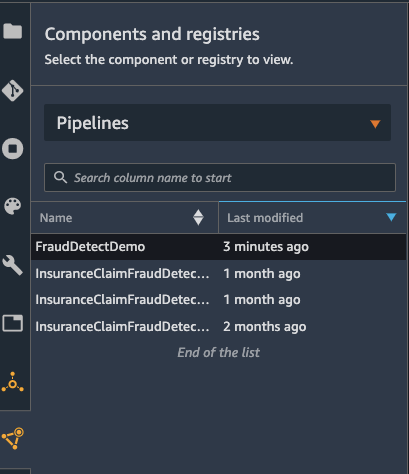

In [ ]:
# Special pipeline parameters can be defined or changed here
parameters = {"TrainingInstance": "ml.m5.xlarge"}

In [ ]:
start_response = pipeline.start(parameters=parameters)

In [ ]:
start_response.wait(delay=60, max_attempts=500)
start_response.describe()

<pre>
</pre>

###after completion it will look something like this
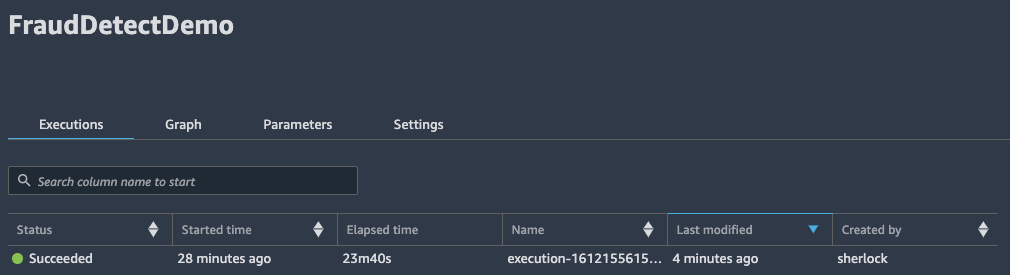

![Pipeline](./images/pipeline-success.png)

## Clean Up
----
After running the demo, you should remove the resources which were created. You can also delete all the objects in the project's S3 directory by passing the keyword argument `delete_s3_objects=True`.

In [ ]:
from demo_helpers import delete_project_resources

In [ ]:
delete_project_resources(
    sagemaker_boto_client=sagemaker_boto_client,
    pipeline_name=pipeline_name,
    mpg_name=mpg_name,
    prefix=prefix,
    delete_s3_objects=False,
    bucket_name=bucket,
)

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/end_to_end|fraud_detection|pipeline-e2e.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/end_to_end|fraud_detection|pipeline-e2e.ipynb)
